# Install Requirements

In [1]:
%pip install transformers datasets
%pip install torch
%pip install matplotlib
%pip install umap-learn
%pip install pandas matplotlib datashader bokeh holoviews colorcet scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Language Model

In [3]:
#MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled" # NL MODEL TODO: is the model trained on lowercased data?

MODEL_NAME = "roberta-base"

#MODEL_NAME = "xlm-roberta-base" # cross-lingual mode (https://huggingface.co/xlm-roberta-base)


In [4]:
from transformers import RobertaModel, AutoTokenizer, RobertaPreTrainedModel, BertModel, GPT2Model, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline('feature-extraction', model=MODEL_NAME, tokenizer=tokenizer)

/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load Data

In [5]:
from pathlib import Path

DATA_DIR = Path.cwd() / "data"

## SemEval 2020 (C)COHA corpus

### Download

In [6]:
from io import BytesIO
from zipfile import ZipFile
import urllib

SEMEVAL_DATA_URL = "https://www2.ims.uni-stuttgart.de/data/sem-eval-ulscd/semeval2020_ulscd_eng.zip"

SEMEVAL2020_DIR = DATA_DIR / "semeval2020_ulscd_eng"

if SEMEVAL2020_DIR.is_dir():
    print(f"Directory '{SEMEVAL2020_DIR}' already exists, skipping corpus download.")
else:
    with urllib.request.urlopen(SEMEVAL_DATA_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(DATA_DIR)

assert SEMEVAL2020_DIR.is_dir(), f"Directory does not exist: '{SEMEVAL2020_DIR}'"


Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/semeval2020_ulscd_eng' already exists, skipping corpus download.


In [7]:
CORPUS1_DIR = SEMEVAL2020_DIR / 'corpus1'
CORPUS2_DIR = SEMEVAL2020_DIR / 'corpus2'
TRUTH_DIR = SEMEVAL2020_DIR / 'truth'

assert CORPUS1_DIR.is_dir(), f"Directory does not exist: '{CORPUS1_DIR}'"
assert CORPUS2_DIR.is_dir(), f"Directory does not exist: '{CORPUS2_DIR}'"
assert TRUTH_DIR.is_dir(), f"Directory does not exist: '{TRUTH_DIR}'"


### Read

In [8]:
TOKENS_FILE1 = CORPUS1_DIR / "token" / "ccoha1.txt.gz"
TOKENS_FILE2 = CORPUS2_DIR / "token" / "ccoha2.txt.gz"

assert TOKENS_FILE1.is_file()
assert TOKENS_FILE2.is_file()

In [9]:
import gzip

with gzip.open(TOKENS_FILE1, 'rt') as f:
    sentences_1810 = f.readlines()

assert len(sentences_1810) == 253644

with gzip.open(TOKENS_FILE2, 'rt') as f:
    sentences_1960 = f.readlines()

assert len(sentences_1960) == 353692

## COHA Corpus (Sample)

### Download

In [10]:
#COHA_DATABASE_URL = 'https://www.corpusdata.org/coha/samples/database.zip'
COHA_TEXT_URL = 'https://www.corpusdata.org/coha/samples/text.zip'

COHA_DIR = DATA_DIR / "COHA"

try:
    COHA_DIR.mkdir(parents=True, exist_ok=False)
except OSError as e:
    print(f"Directory '{COHA_DIR}' already exists: {str(e)}. Skipping corpus download.")
else:
    with urllib.request.urlopen(COHA_TEXT_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(COHA_DIR)

assert COHA_DIR.is_dir()

Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA' already exists: [Errno 17] File exists: '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA'. Skipping corpus download.


### Read CohaDocs

In [11]:
from functools import cached_property
import logging
import re
from typing import Generator, List

FILENAME_PATTERN = r"([a-z]{2,4})_(\d{4})_(\d{3,6})\.txt"
SENTENCE_PATTERN = r"\s*(.*?\s[\.!?\n])"

class CohaDoc:
    _encoding = 'UTF-8'

    def __init__(self, path: Path):
        self._path = path

        try:
            genre, year, id = re.search(FILENAME_PATTERN, self._path.name).groups()
        except AttributeError as e:
            raise ValueError(f"Could not parse path: '{path}': {str(e)}")
        
        self._genre = genre
        self._year = int(year)
        self._id = int(id)

    def __repr__(self) -> str:
        return str(self._path.name)

    def __str__(self) -> str:
        return str(self._path.name)

    @property
    def genre(self) -> str:
        return self._genre

    @property
    def year(self) -> int:
        return self._year

    @property
    def id(self) -> int:
        return self._id
    
    @cached_property
    def text(self):
        with open(self._path, 'rt', encoding=self._encoding) as f:
            return f.read()

    def sentences(self):
        sentences = re.findall(SENTENCE_PATTERN, self.text)
        assert sentences[0].strip() == f"@@{self._id}", f"First line is expected to match document ID ('{self._id}'), but is: {sentences[0]}"
        return sentences[1:]

    def find_sentences(self, term: str) -> List[str]:
        """Find the sentences containing the term. No tokenization done, just string search."""
        return [
            sentence
            for sentence in self.sentences()
            if term in sentence
        ]
        
    def clean_sentences(self):
        # TODO
        return NotImplemented


In [12]:
coha_docs = [CohaDoc(file) for file in COHA_DIR.glob('*.txt')]

assert len(coha_docs) == 1144

(array([ 12.,  13.,  24.,  50.,  60., 156., 206., 188., 247., 188.]),
 array([1817. , 1836.2, 1855.4, 1874.6, 1893.8, 1913. , 1932.2, 1951.4,
        1970.6, 1989.8, 2009. ]),
 <BarContainer object of 10 artists>)

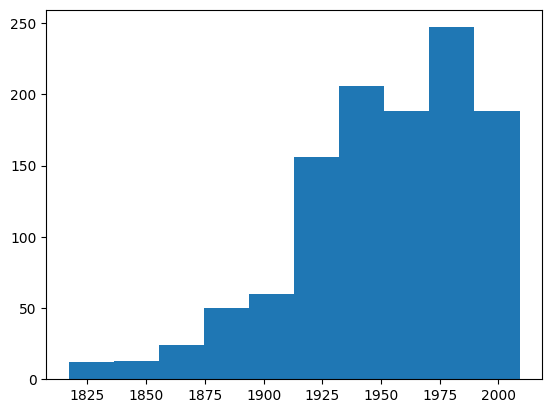

In [13]:
plt.hist([c.year for c in coha_docs])

(array([586.,   0.,   0., 424.,   0.,   0., 108.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

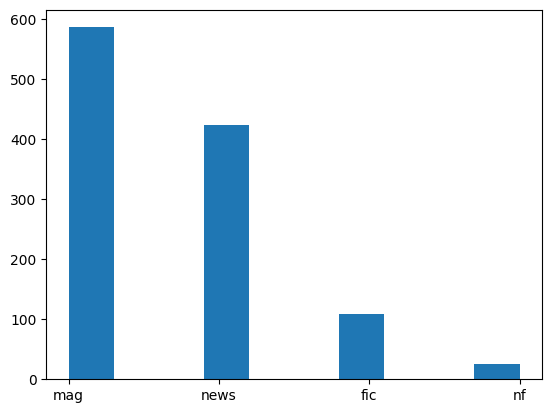

In [14]:
plt.hist([c.genre for c in coha_docs])

# Embeddings

In [15]:
TERM = 'cell'

## Find Relevant Sentences

In [20]:
import collections
from dataclasses import dataclass
from functools import cache
from itertools import islice
from typing import Iterable, List, Optional, Tuple
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline
from numpy.typing import ArrayLike

def sliding_window(iterable, n):
    # From https://docs.python.org/3/library/itertools.html#itertools-recipes
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


@dataclass
class Sentence:
    text: str
    coha_doc: CohaDoc
    model: FeatureExtractionPipeline

    def __contains__(self, s: str):
        return s in self.text

    @property
    def year(self) -> Optional[int]:
        return self.coha_doc.year

    @property
    def tokenizer(self):
        return self.model.tokenizer

    @cached_property
    def _embeddings(self):
        return self.model(self.text)[0]

    @cached_property
    def _token_ids(self):
        return self.tokenizer(self.text)['input_ids']

    def embeddings_matrix(self, token: str) -> List[ArrayLike]:
        return [
                self._aggregate_embeddings(token_i, token_length)
                for token_i, token_length in self._find_token(token)
            ]

    def _find_token(self, token: str, max_n: int = 5) -> Tuple[int, int]:
        """
        Find sequences of (sub-word) tokens that match a (word) token if merged

        Args:
            - token: a token (word) to find, exact match
            - max_n: the maximum number of sub-word tokens to be merged
        Yields: Tuple[int, int]: the token index and the length (number of tokens to be merged)
        """
        # FIXME: do not return tokens that are part of a word
        _tokens = model.tokenizer.convert_ids_to_tokens(self._token_ids)

        for n in range(max_n):
            for i, window in enumerate(sliding_window(_tokens, n)):
                _token = model.tokenizer.convert_tokens_to_string(window)
                if _token.strip() == token:
                    yield i, n

    def _aggregate_embeddings(self, token_start_index: int, n_tokens: int) -> ArrayLike:
        """Return a one-dimensional array of the (aggregated) token embedding(s).
        
        Args:
            - token_start_index: the token position in the sentence, according to the model's tokenizer
            - n_tokens: the number of tokens to aggregate (1 for a single token)
        
        Returns:
            A vector of shape (<embedding dimensionlaity, 1)
            for the token embedding at the given position, or the mean of multiple token embeddings
        """
        a: np.array
        if n_tokens == 1:
            a = np.array(self._embeddings[token_start_index])
        else:
            a = np.array(self._embeddings[token_start_index:token_start_index+n_tokens]).mean(axis=0)
        assert a.shape == (model.model.config.hidden_size, ), f"Invalid shape: {a.shape} for token index {token_start_index}, token length {n_tokens}."
        return a
        



In [21]:
from tqdm import tqdm

# TODO: this could be a generator
sentence_candidates: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM)
]

print(len(sentence_candidates))

100%|██████████| 1144/1144 [00:00<00:00, 1613.46doc/s]

622


## Compute Embeddings

In [22]:
embeddings = [] # Changed into array below for efficiency
sentences = []

for sentence in tqdm(sentence_candidates, unit='sentence', desc=f"Embeddings for '{TERM}'"):
    for embedding in sentence.embeddings_matrix(TERM):
        embeddings.append(embedding)
        sentences.append(sentence)

assert len(embeddings) == len(sentences)
len(embeddings)

Embeddings for 'cell': 100%|██████████| 622/622 [00:33<00:00, 18.42sentence/s]


143

In [23]:
embeddings = np.array(embeddings)

assert embeddings.shape == (len(sentences), model.model.config.hidden_size), f"Shape {embeddings.shape} does not match expected shape {(len(sentences), model.model.config.hidden_size)}"
embeddings.shape

(143, 768)

In [24]:
sentences[0]

Sentence(text='" Please remember , Excellency , we will only be visiting the United States for a year .', coha_doc=fic_1979_10650.txt, model=<transformers.pipelines.feature_extraction.FeatureExtractionPipeline object at 0x7fa93a419300>)

# Plot

## PCA

In [25]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(embeddings)

Text(0.5, 1.0, "PCA Embeddings projections for 'cell'")

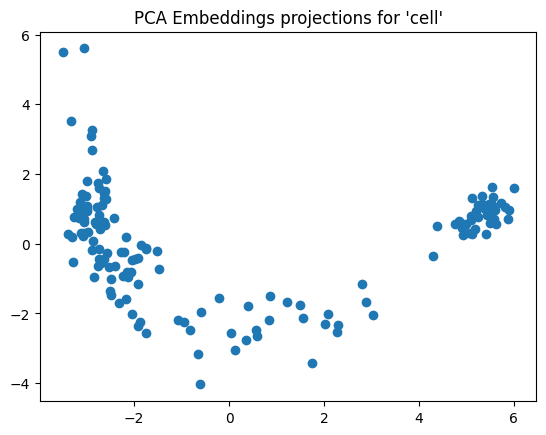

In [26]:
plt.scatter(X_pca[:,0], X_pca[:,1], label=TERM)
plt.title(f"PCA Embeddings projections for '{TERM}'")

## UMAP

In [27]:
def get_decade(sentence: Sentence) -> str:
    start = int(sentence.coha_doc.year / 10) * 10
    end = start + 10
    return f"{start} - {end}"

hover_data = pd.DataFrame(data = {
        'doc': [sentence.coha_doc._path.name for sentence in sentences],
        'text': [sentence.text for sentence in sentences],
        'year': [sentence.coha_doc.year for sentence in sentences],
        'decade': [get_decade(sentence) for sentence in sentences],
    }
)

# TOOD: add match index for each sentence

assert len(hover_data) == len(embeddings), f"Number of embeddings ({len(embeddings)}) must equal number of sentence data points ({len(hover_data)})."
hover_data


,doc,text,year,decade
0,fic_1979_10650.txt,""" Please remember , Excellency , we will only ...",1979,1970 - 1980
1,fic_1979_10650.txt,""" For what you have done , Excellency ?",1979,1970 - 1980
2,fic_1979_10650.txt,""" But Senor de Tormes is going with us , Excel...",1979,1970 - 1980
3,fic_1979_10650.txt,""" De Tormes was murdered , Your Excellency , ""...",1979,1970 - 1980
4,fic_1979_10650.txt,""" "" That 's an ugly conjecture , Your Excellen...",1979,1970 - 1980
...,...,...,...,...
138,news_1894_673550.txt,"Malcolm D. Peckham , who is supposed to have b...",1894,1890 - 1900
139,mag_1910_430450.txt,In the matter of ethical ideals and common mor...,1910,1910 - 1920
140,mag_1904_486450.txt,"? Houghton , Mifflin &; Co. complete their cen...",1904,1900 - 1910
141,mag_1904_486450.txt,"Emerson 's "" Historical Discourse at Concord ""...",1904,1900 - 1910


In [28]:
import umap
mapper = umap.UMAP().fit(embeddings)

In [29]:
import umap.plot

umap.plot.output_notebook()

title = f"UMAP Embeddings Projections for '{TERM}'"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loading BokehJS ...

### Points (static)

Text(0.5, 1.0, "UMAP Embeddings Projections for 'cell'")

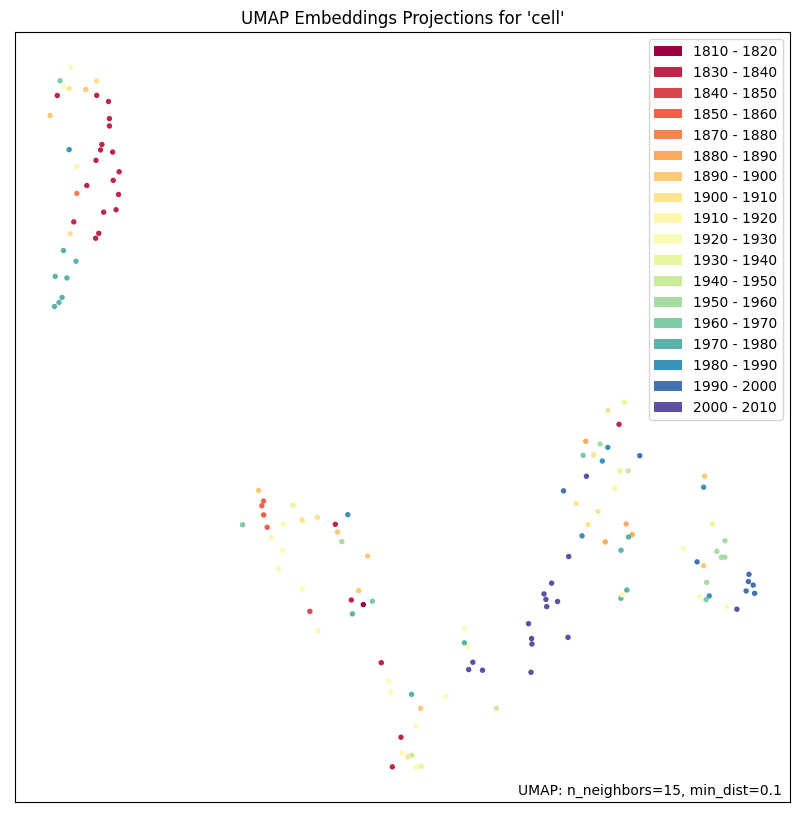

In [30]:
subplot = umap.plot.points(mapper, height=1000, width=1000, labels = hover_data['decade'])
subplot.set_title(title)


### Interactive Plot (using Bokeh)

In [31]:
from bokeh.models import ColumnDataSource

cds = ColumnDataSource(data={
        'x': mapper.embedding_[:,0],
        'y': mapper.embedding_[:,1],
    } | hover_data.to_dict('list')
)

cds

ColumnDataSource(id='1003', ...)

In [32]:
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
import bokeh.palettes

categories = hover_data.decade.unique()
palette = bokeh.palettes.Category20[len(categories)]

assert len(palette) >= len(categories), f"Palette has only {len(palette)} categories, but {len(categories)} needed."

color_mapper = CategoricalColorMapper(factors=categories, palette=palette)
color_mapper

CategoricalColorMapper(id='1008', ...)

In [33]:
from bokeh.plotting import figure, show

p = figure(height=1000, width=1000, tooltips=[('doc', '@doc'), ('text', '@text'), ('year', '@year')])
p.title = title

# TODO: group by decade to enable muting individually via legend
p.dot(
    x='x', y='y', legend_field = 'decade', source=cds,
    size=20,
    color={'field': 'decade', 'transform': color_mapper}
)

p.legend.click_policy="mute"

show(p)